# <font color='red'>Clustering Assignment</font>

**There will be some functions that start with the word "grader" ex: grader_actors(), grader_movies(), grader_cost1() etc, you should not change those function definition.<br><br>Every Grader function has to return True.**

**Please check [clustering assignment helper functions](https://drive.google.com/file/d/1V29KhKo3YnckMX32treEgdtH5r90DIjU/view?usp=sharing) notebook before attempting this assignment.**

*  Read graph from the given <font color='blue'>movie_actor_network.csv</font> (note that the graph is bipartite graph.)

*  Using stellergaph and gensim packages, get the dense representation(128dimensional vector) of every node in the graph. [Refer <font color='blue'>Clustering_Assignment_Reference.ipynb</font>]

* Split the dense representation into actor nodes, movies nodes.(Write you code in <font color='blue'>def data_split()</font>)


# <font color='red'>Task 1 : Apply clustering algorithm to group similar actors</font>

 1. For this task consider only the actor nodes 
 2. Apply any clustering algorithm of your choice <br>
    Refer : https://scikit-learn.org/stable/modules/clustering.html
 3. Choose the number of clusters for which you have maximum score of <b>$Cost1*Cost2$</b><br>
 4. Cost1 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(number of nodes in the largest connected component in the graph with the actor nodes and its movie neighbours in cluster i)}}{\text{(total number of nodes in that cluster i)}}$ where N= number of clusters 
<br> (Write your code in <font color='blue'>def cost1()</font>)<br>
 5. Cost2 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(sum of degress of actor nodes in the graph with the actor nodes and its movie neighbours in cluster i)}}{\text{(number of unique movie nodes in the graph with the actor nodes and its movie neighbours in cluster i)}}$ where N= number of clusters 
 <br> (Write your code in <font color='blue'>def cost2()</font>)<br>
 6. Fit the clustering algorithm with the opimal number_of_clusters and get the cluster number for each node <br>
 7. Convert the d-dimensional dense vectors of nodes into 2-dimensional using dimensionality reduction techniques (preferably TSNE)<br>
 8. Plot the 2d scatter plot, with the node vectors after step e and give colors to nodes such that same cluster nodes will have same color

<img src='https://i.imgur.com/4SPYPFa.jpg'>

# <font color='red'>Task 2 : Apply clustering algorithm to group similar movies</font>


1. For this task consider only the movie nodes
2. Apply any clustering algorithm of your choice
3.Choose the number of clusters for which you have maximum score of $Cost1*Cost2$ <br>

    Cost1 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(number of nodes in the largest connected component in the graph with the movie nodes and its actor neighbours in cluster i)}}{\text{(total number of nodes in that cluster i)}}$ where N= number of clusters <br>
(Write your code in <font color='blue'>def cost1()</font>)<br>
	
4. Cost2 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(sum of degress of movie nodes in the graph with the movie nodes and its actor neighbours in cluster i)}}{\text{(number of unique actor nodes in the graph with the movie nodes and its actor neighbours in cluster i)}}$ 
where N= number of clusters 
<br>(Write your code in <font color='blue'>def cost2()</font>)<br>


**Algorithm for actor nodes**

<pre>
	for number_of_clusters in [3, 5, 10, 30, 50, 100, 200, 500]:
		algo = clustering_algorith(clusters=number_of_clusters)
        # you will be passing a matrix of size N*d where N number of actor nodes and d is dimension from gensim
		algo.fit(the dense vectors of actor nodes) 
        You can get the labels for corresponding actor nodes (algo.labels_)
        Create a graph for every cluster(ie., if n_clusters=3, create 3 graphs)
        (You can use ego_graph to create subgraph from the actual graph)
        compute cost1,cost2 
           (if n_cluster=3, cost1=cost1(graph1)+cost1(graph2)+cost1(graph3) # here we are doing summation
            cost2=cost2(graph1)+cost2(graph2)+cost2(graph3)
		computer the metric Cost = Cost1*Cost2
	return number_of_clusters which have maximum Cost
	</pre>

<br>

In [277]:
#!pip install networkx==2.3

In [278]:
import networkx as nx
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
# you need to have tensorflow 
from stellargraph.data import UniformRandomMetaPathWalk
from stellargraph import StellarGraph

In [279]:
data=pd.read_csv('movie_actor_network.csv', index_col=False, names=['movie','actor'])

In [280]:
edges = [tuple(x) for x in data.values.tolist()]

In [281]:
B = nx.Graph()
B.add_nodes_from(data['movie'].unique(), bipartite=0, label='movie')
B.add_nodes_from(data['actor'].unique(), bipartite=1, label='actor')
B.add_edges_from(edges, label='acted')

In [282]:
A = (B.subgraph(c) for c in nx.connected_components(B))
A = list(A)[0]

In [283]:
print("number of nodes", A.number_of_nodes())
print("number of edges", A.number_of_edges())

number of nodes 4703
number of edges 9650


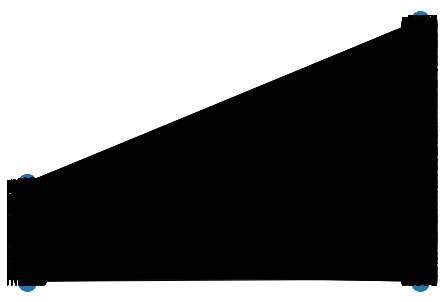

In [284]:
l, r = nx.bipartite.sets(A)
pos = {}

pos.update((node, (1, index)) for index, node in enumerate(l))
pos.update((node, (2, index)) for index, node in enumerate(r))
  
nx.draw(A, pos=pos, with_labels=True)
plt.show()

In [285]:
movies = []
actors = []
for i in A.nodes():
    if 'm' in i:
        movies.append(i)
    if 'a' in i:
        actors.append(i)
print('number of movies ', len(movies))
print('number of actors ', len(actors))

number of movies  1292
number of actors  3411


In [286]:
# Create the random walker
rw = UniformRandomMetaPathWalk(StellarGraph(A))

# specify the metapath schemas as a list of lists of node types.
metapaths = [
    ["movie", "actor", "movie"],
    ["actor", "movie", "actor"] ]

walks = rw.run(nodes=list(A.nodes()), # root nodes
               length=100,  # maximum length of a random walk
               n=1,        # number of random walks per root node 
               metapaths=metapaths
              )

print("Number of random walks: {}".format(len(walks)))

Number of random walks: 4703


In [287]:
from gensim.models import Word2Vec
model = Word2Vec(walks, vector_size=128, window=5)

In [288]:
model.wv.vectors.shape  # 128-dimensional vector for each node in the graph

(4703, 128)

In [289]:
# Retrieve node embeddings and corresponding subjects
node_ids = model.wv.index_to_key  # list of node IDs
node_embeddings = model.wv.vectors  # numpy.ndarray of size number of nodes times embeddings dimensionality
node_targets = [ A.nodes[node_id]['label'] for node_id in node_ids]

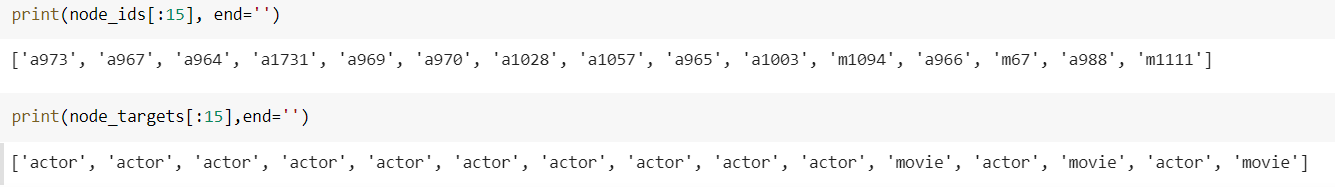

In [290]:
print(node_ids[0:15], end='')

['a973', 'a967', 'a964', 'a1731', 'a970', 'a1028', 'a969', 'a965', 'a1057', 'a1003', 'm1111', 'a988', 'a959', 'm1094', 'a966']

In [291]:
print(node_targets[:15], end='')

['actor', 'actor', 'actor', 'actor', 'actor', 'actor', 'actor', 'actor', 'actor', 'actor', 'movie', 'actor', 'actor', 'movie', 'actor']

In [292]:
print(node_embeddings[:15])

[[ 2.0308554  -0.0499885   2.352832   ...  1.6980735  -0.5776359
   1.3687824 ]
 [ 1.9934652  -0.5161803   2.1398098  ...  1.2515384  -2.6802204
   2.0761383 ]
 [ 2.3348165  -1.177147    2.2662106  ...  1.442109   -0.8406095
   1.234259  ]
 ...
 [ 2.7582424  -0.3099918   2.6396327  ...  1.5865242  -0.5123547
   2.9932363 ]
 [ 1.6001581  -2.0150146  -1.8967937  ... -1.358863    0.56158024
  -0.7280189 ]
 [ 2.4929461  -1.1175051   1.3327527  ...  0.933033   -0.9685621
   1.3641598 ]]


## Data Split

In [293]:
def data_split(node_ids, node_targets, node_embeddings):
    '''In this function, we will split the node embeddings into actor_embeddings , movie_embeddings '''
    actor_nodes, movie_nodes = [], []
    actor_embeddings, movie_embeddings = [], []
    # split the node_embeddings into actor_embeddings, movie_embeddings based on node_ids
    # By using node_embedding and node_targets, we can extract actor_embedding and movie embedding
    # By using node_ids and node_targets, we can extract actor_nodes and movie nodes
    
    for index, i_d in enumerate(node_ids):
        if node_targets[index] == 'actor':
            actor_nodes.append(i_d)
            actor_embeddings.append(node_embeddings[index])
        else:    # elif node_targets[index]=='movie':
            movie_nodes.append(i_d)
            movie_embeddings.append(node_embeddings[index])
    return actor_nodes, movie_nodes, actor_embeddings, movie_embeddings


In [294]:
actor_nodes, movie_nodes, actor_embeddings, movie_embeddings = data_split(node_ids, node_targets, node_embeddings)

<font color='cyan'>Grader function - 1</font>

In [295]:
def grader_actors(data):
    assert(len(data)==3411)
    return True
grader_actors(actor_nodes)

True

<font color='cyan'>Grader function - 2</font>

In [296]:
def grader_movies(data):
    assert(len(data)==1292)
    return True
grader_movies(movie_nodes)

True

<font color='blue'>Calculating cost1</font>

Cost1 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(number of nodes in the largest connected component in the graph with the actor nodes and its movie neighbours in cluster i)}}{\text{(total number of nodes in that cluster i)}}$ where N= number of clusters <br><br>
<br>

In [297]:
def cost1(graph, number_of_clusters):
    '''In this function, we will calculate cost1'''
    # calculate cost1
    # cost1 = (1/number_of_clusters) * ( len(max(nx.connected_components(graph), key=len)) / graph.number_of_nodes() )
    max_nodes = len(max(nx.connected_components(graph)))
    total_nodes = graph.number_of_nodes()
    cost1 = max_nodes / (total_nodes * number_of_clusters)
    return cost1

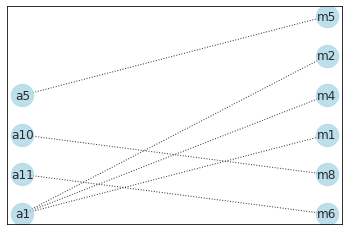

In [298]:
import networkx as nx
from networkx.algorithms import bipartite
graded_graph= nx.Graph()
graded_graph.add_nodes_from(['a1','a5','a10','a11'], bipartite=0) # Add the node attribute "bipartite"
graded_graph.add_nodes_from(['m1','m2','m4','m6','m5','m8'], bipartite=1)
graded_graph.add_edges_from([('a1','m1'),('a1','m2'),('a1','m4'),('a11','m6'),('a5','m5'),('a10','m8')])
l={'a1','a5','a10','a11'};r={'m1','m2','m4','m6','m5','m8'}
pos = {}
pos.update((node, (1, index)) for index, node in enumerate(l))
pos.update((node, (2, index)) for index, node in enumerate(r))
nx.draw_networkx(graded_graph, pos=pos, with_labels=True,node_color='lightblue',alpha=0.8,style='dotted',node_size=500)

<font color='cyan'>Grader function - 3</font>

In [299]:
graded_cost1=cost1(graded_graph,3)
def grader_cost1(data):
    assert(data==((1/3)*(4/10))) # 1/3 is number of clusters
    return True
grader_cost1(graded_cost1)

True

<font color='blue'>Calculating cost2</font>

Cost2 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(sum of degress of actor nodes in the graph with the actor nodes and its movie neighbours in cluster i)}}{\text{(number of unique movie nodes in the graph with the actor nodes and its movie neighbours in cluster i)}}$ where N= number of clusters 

In [300]:
def cost2(graph,number_of_clusters):
    '''In this function, we will calculate cost2'''
    
    '''
    neighbour_nodes = []
    for i in graph.nodes():
        if 'm' in i: # using 'm' coz neighobour nodes are movies nodes 
            neighbour_nodes.append(i)

    # calculate cost2
    cost2 = (1/number_of_clusters) * ( (len(neighbour_nodes)) / len(graded_graph.edges) )
    '''
    num = sum([graph.degree(i) for i in graph.nodes if "a" in i ])
    denn = len([j for j in graph.nodes if "m" in j])
    cost2 = num / (denn * number_of_clusters)

    return cost2

<font color='cyan'>Grader function - 4</font>

In [301]:
graded_cost2=cost2(graded_graph,3)
def grader_cost2(data):
    assert(data==((1/3)*(6/6))) # 1/3 is number of clusters
    return True
grader_cost2(graded_cost2)

True

# <font color='blue'>Task - 1</font>

<font color='blue'>Grouping similar actors</font>

In [302]:
list_cost = []
number_of_clusters = [3, 5, 10, 30, 50, 100, 200, 500]
for k in number_of_clusters:
    algo = KMeans(n_clusters=k, random_state=0)
    algo.fit(np.array(actor_embeddings))
    #labels = algo.labels_
    sub_cost1 = 0
    sub_cost2 = 0
    for i in range(k):
        sub_graph = nx.Graph()
        # find m[index] for i
        sub_nodes = np.array(actor_nodes).reshape(len(actor_nodes))[algo.labels_==i].tolist()
        for j in sub_nodes:
            sub_graph.add_nodes_from(nx.ego_graph(B,j).nodes)
            sub_graph.add_edges_from(nx.ego_graph(B,j).edges())
        sub_cost1 += cost1(sub_graph, k)
        sub_cost2 += cost2(sub_graph, k)

    print("Total cost for cluster number: " +str(k)+ ": " +str(sub_cost1 * sub_cost2))
    list_cost.append(sub_cost1 * sub_cost2)
kmax_for_actor = number_of_clusters[list_cost.index(max(list_cost))]
print("Maximum product of costs: " +str(max(list_cost)))
print("Maximum value of cost for actors at: " +str(kmax_for_actor))

Total cost for cluster number: 3: 3.7219905548100964
Total cost for cluster number: 5: 2.526251360674733
Total cost for cluster number: 10: 2.0814729960738307
Total cost for cluster number: 30: 1.6580895359635655
Total cost for cluster number: 50: 1.5592015443838751
Total cost for cluster number: 100: 1.4690837747895031
Total cost for cluster number: 200: 1.6526847247589422
Total cost for cluster number: 500: 1.8989920523735175
Maximum product of costs: 3.7219905548100964
Maximum value of cost for actors at: 3


<font color='blue'>Displaying similar actor clusters</font>

In [303]:
from sklearn.manifold import TSNE
transform = TSNE #PCA

trans = transform(n_components=2)
node_embeddings_2d = trans.fit_transform(actor_embeddings)

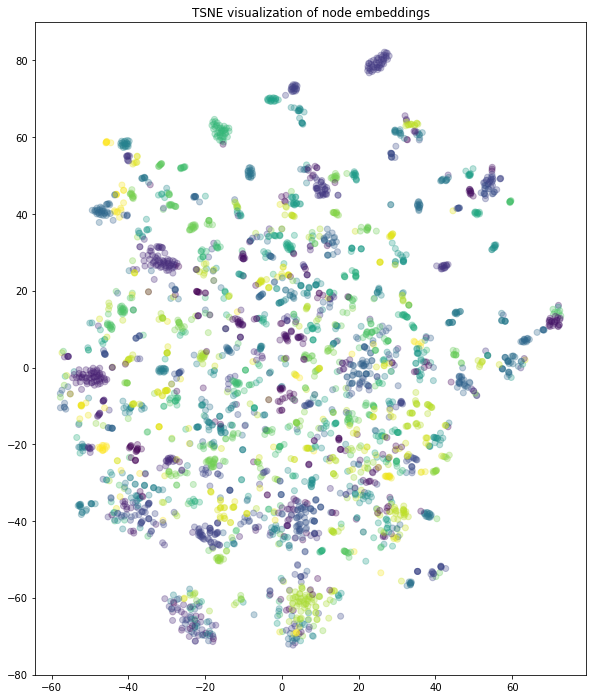

In [304]:
# draw the points

label_map = { l: i for i, l in enumerate(np.unique(list(algo.labels_)))}
node_colours = [ label_map[target] for target in list(algo.labels_)]

plt.figure(figsize=(12,12))
plt.axes().set(aspect="equal")
plt.scatter(node_embeddings_2d[:,0], 
            node_embeddings_2d[:,1], 
            c=node_colours, alpha=0.3)
plt.title('{} visualization of node embeddings'.format(transform.__name__))

plt.show()

# <font color='blue'>Task - 2</font>

<font color='blue'>Grouping similar movies</font>

In [305]:
list_cost = []
number_of_clusters = [3, 5, 10, 30, 50, 100, 200, 500]
for k in number_of_clusters:
    algo = KMeans(n_clusters=k, random_state=0)
    algo.fit(np.array(movie_embeddings))
    #labels = algo.labels_
    sub_cost1 = 0
    sub_cost2 = 0
    for i in range(k):
        sub_graph = nx.Graph()
        # find a[index] for i
        sub_nodes = np.array(movie_nodes).reshape(len(movie_nodes))[algo.labels_==i].tolist()
        for j in sub_nodes:
            sub_graph.add_nodes_from(nx.ego_graph(B,j).nodes)
            sub_graph.add_edges_from(nx.ego_graph(B,j).edges())
        sub_cost1 += cost1(sub_graph,k)
        sub_cost2 += cost2(sub_graph,k)

    print("Total cost for cluster number: " +str(k)+ ": " +str(sub_cost1 * sub_cost2))
    list_cost.append(sub_cost1 * sub_cost2)
kmax_for_movie = number_of_clusters[list_cost.index(max(list_cost))]
print("Maximum product of costs: " +str(max(list_cost)))
print("Maximum value of cost for movies at: " +str(kmax_movie))

Total cost for cluster number: 3: 8.411725557443619
Total cost for cluster number: 5: 8.773892003857874
Total cost for cluster number: 10: 8.69339352376219
Total cost for cluster number: 30: 12.1147087456522
Total cost for cluster number: 50: 13.593578860189147
Total cost for cluster number: 100: 13.612324416336508
Total cost for cluster number: 200: 12.68470641584924
Total cost for cluster number: 500: 10.399104993864198
Maximum product of costs: 13.612324416336508
Maximum value of cost for movies at: 50


<font color='blue'>Displaying similar movie clusters</font>

In [306]:
transform = TSNE #PCA

trans = transform(n_components=2)
node_embeddings_2d = trans.fit_transform(movie_embeddings)

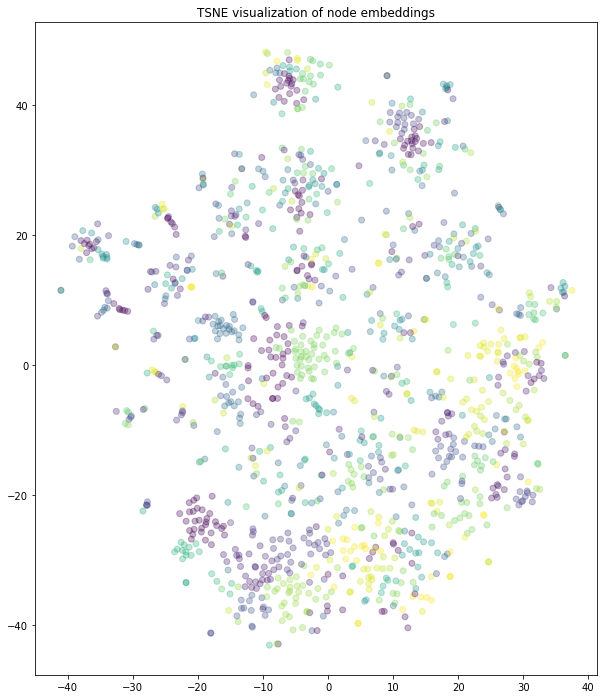

In [307]:
# draw the points

label_map = { l: i for i, l in enumerate(np.unique(list(algo.labels_)))}
node_colours = [ label_map[target] for target in list(algo.labels_)]

plt.figure(figsize=(12,12))
plt.axes().set(aspect="equal")
plt.scatter(node_embeddings_2d[:,0], 
            node_embeddings_2d[:,1], 
            c=node_colours, alpha=0.3)
plt.title('{} visualization of node embeddings'.format(transform.__name__))

plt.show()